## Training a Neural Network Model

- using `pytorch`

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [29]:
import sys
import os
import copy
import numpy as np
import tqdm

# Add the path to the 'code' directory
sys.path.append(os.path.abspath('../code'))

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

# include feature engineering pipeline
from feature_eng_pipeline import pipeline_nn, process_new_data

In [31]:
# switch to using CUDA - GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [32]:
torch.cuda.is_available()

True

In [33]:
# loading data
data_path = '../../data/mean_with_labels.csv'

class RNANanoporeDataset(Dataset):
    """Dataset used to train and test RNA Nanopore data"""

    def __init__(self, csv_file):
        """Initializes instance of class RNANanoporeDataset.

        Args:
            csv_file (str): Path to the csv file with the nanopore data
        """

        self.df = pd.read_csv(csv_file)
        v, s, X_df, y_df = pipeline_nn(self.df)
        #X_drop = X_df.drop(["transcript_name", "gene_id", "nucleotide_seq"], axis=1).reset_index(drop=True)  

        # keep all trigram columns in input dataset
        self.X = X_df
        self.y = y_df.reset_index(drop=True).squeeze()  
        self.v = v #need the vectorizer 
        self.s = s #need the standardizer

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
    # Handle if idx is a tensor (converting to list if needed)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        signal_features = self.X.iloc[idx].values  
        label = self.y.iloc[idx]  

        # Convert to tensors
        signal_features = torch.tensor(signal_features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return signal_features, label
    
    def get_size(self):
        return len(self)


In [34]:
dataset = RNANanoporeDataset(data_path)

# split data by 80-20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Dataloaders
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

In [71]:
# Extract a single batch from trainloader to check feature dimension
sample_features, _ = next(iter(trainloader))

# Get the number of features (usually the second dimension of the tensor)
num_features = sample_features.shape[1]

print(f"Number of features: {num_features}")

Number of features: 79


In [35]:
class ModNet(nn.Module):
    def __init__(self, signal_input_dim):
        super(ModNet, self).__init__()

        # Read-level Encoder: MLP with two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(signal_input_dim, 150),  # Change hidden dimensions as needed
            nn.ReLU(),
            nn.Linear(150, 32),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout layer for generalizing
            nn.Linear(32, 1)  # Single output for binary classification
        )

    def forward(self, signal_features):
        read_level_probs = self.encoder(signal_features)
        return torch.sigmoid(read_level_probs)  # Apply sigmoid for probabilities

    def noisy_or_pooling(self, read_level_probs):
        """
        :param read_level_probs: Tensor of shape (batch_size, 1)
        :return: Site-level modification probability for each site (batch_size, 1)
        """
        site_level_probs = 1 - torch.prod(1 - read_level_probs, dim=1)
        return site_level_probs


In [36]:
# Set CUDA launch blocking for better error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [62]:
# based on dataset size
model = ModNet(signal_input_dim=len(dataset.X.columns)) 

# Binary Cross-Entropy Loss for binary classification
criterion = nn.BCEWithLogitsLoss() 

# Modified optimizer with gradient clipping
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
def train_model_with_checks(model, trainloader, criterion, optimizer, num_epochs=10):
    """
    Training loop with dimension checks
    """
    model.to(device)
    model.train()
    
    # Get expected input dimension from model's first layer
    first_layer = next(model.parameters())
    expected_input_dim = len(dataset.X.columns)
    
    print(f"\nModel Input Dimension Check:")
    print(f"Expected input dimension: {expected_input_dim}")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            signal_features, labels = data
            
            # Check dimensions before forward pass
            current_input_dim = signal_features.shape[1]
            if current_input_dim != expected_input_dim:
                raise ValueError(
                    f"Input dimension mismatch! Model expects {expected_input_dim} "
                    f"features but got {current_input_dim} features. "
                    f"Full input shape: {signal_features.shape}"
                )
            
            signal_features = signal_features.to(device)
            labels = labels.to(device).float()
            
            try:
                # Forward pass
                read_level_probs = model(signal_features)
                site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()

                if site_level_probs.dim() > 1:
                    site_level_probs = site_level_probs.squeeze()
                
                # Compute loss
                loss = criterion(site_level_probs, labels)
                
                # Zero gradients, backward pass, and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                if i % 10 == 9:
                    print(f'Epoch [{epoch+1}/{num_epochs}], '
                          f'Batch [{i+1}/{len(trainloader)}], '
                          f'Loss: {running_loss/10:.4f}')
                    running_loss = 0.0
                    
            except RuntimeError as e:
                print(f"\nError in batch {i}:")
                print(f"Input shape: {signal_features.shape}")
                print(f"Label shape: {labels.shape}")
                print(f"Error message: {str(e)}")
                raise e
    
    print('Finished Training')

model_1 = copy.deepcopy(model)

losses = train_model_with_checks(model_1, trainloader, criterion, optimizer, num_epochs=10)


Model Input Dimension Check:
Expected input dimension: 79
Epoch [1/10], Batch [10/659], Loss: 0.7556
Epoch [1/10], Batch [20/659], Loss: 0.7561
Epoch [1/10], Batch [30/659], Loss: 0.7445
Epoch [1/10], Batch [40/659], Loss: 0.7613
Epoch [1/10], Batch [50/659], Loss: 0.7554
Epoch [1/10], Batch [60/659], Loss: 0.7623
Epoch [1/10], Batch [70/659], Loss: 0.7540
Epoch [1/10], Batch [80/659], Loss: 0.7474
Epoch [1/10], Batch [90/659], Loss: 0.7615
Epoch [1/10], Batch [100/659], Loss: 0.7589
Epoch [1/10], Batch [110/659], Loss: 0.7550
Epoch [1/10], Batch [120/659], Loss: 0.7536
Epoch [1/10], Batch [130/659], Loss: 0.7544
Epoch [1/10], Batch [140/659], Loss: 0.7526
Epoch [1/10], Batch [150/659], Loss: 0.7537
Epoch [1/10], Batch [160/659], Loss: 0.7552
Epoch [1/10], Batch [170/659], Loss: 0.7500
Epoch [1/10], Batch [180/659], Loss: 0.7472
Epoch [1/10], Batch [190/659], Loss: 0.7498
Epoch [1/10], Batch [200/659], Loss: 0.7546
Epoch [1/10], Batch [210/659], Loss: 0.7494
Epoch [1/10], Batch [220/6

In [64]:
# Function to evaluate on the test set
def evaluate_model(model, testloader, criterion, device):
    model.eval()  
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    model.to(device)

    with torch.no_grad():
        for data in testloader:
            signal_features, labels = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()  # Shape: (batch_size,)

            # Compute loss
            loss = criterion(site_level_probs, labels.float())
            total_loss += loss.item()

            # Collect predictions and labels for ROC and PR AUC
            all_labels.append(labels.cpu())
            all_predictions.append(site_level_probs.cpu())

    # Convert lists to tensors
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    # Compute ROC-AUC and PR-AUC
    roc_auc = roc_auc_score(all_labels, all_predictions)
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    pr_auc = auc(recall, precision)

    # Average loss
    avg_loss = total_loss / len(testloader)
    
    print(f'Test Loss: {avg_loss:.4f}, ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}')
    
    return avg_loss, roc_auc, pr_auc

evaluate_model(model_1, testloader, criterion, device=device)

Test Loss: 0.7381, ROC-AUC: 0.5655, PR-AUC: 0.4763


(0.738083400148334,
 np.float64(0.5655176475052923),
 np.float64(0.47625912407912985))

## Test B: Implement Early Stopping

In [68]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model_with_early_stopping(
    model, trainloader, testloader, criterion, optimizer, num_epochs=10, patience=10
):
    """
    Training loop with dimension checks and early stopping.
    """
    early_stopping = EarlyStopping(patience=patience)
    model.to(device)
    model.train()
    
    # Get expected input dimension from model's first layer
    first_layer = next(model.parameters())
    expected_input_dim = len(dataset.X.columns)
    
    print(f"\nModel Input Dimension Check:")
    print(f"Expected input dimension: {expected_input_dim}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            signal_features, labels = data
            
            # Check dimensions before forward pass
            current_input_dim = signal_features.shape[1]
            if current_input_dim != expected_input_dim:
                raise ValueError(
                    f"Input dimension mismatch! Model expects {expected_input_dim} "
                    f"features but got {current_input_dim} features. "
                    f"Full input shape: {signal_features.shape}"
                )
            
            signal_features = signal_features.to(device)
            labels = labels.to(device).float()
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()
            if site_level_probs.dim() > 1:
                site_level_probs = site_level_probs.squeeze()
            
            # Compute loss
            loss = criterion(site_level_probs, labels)
            
            # Zero gradients, backward pass, and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 10 == 9:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/10:.4f}')
                running_loss = 0.0
        
        # Validation phase for early stopping check
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_data in testloader:
                val_signal_features, val_labels = val_data
                val_signal_features = val_signal_features.to(device)
                val_labels = val_labels.to(device).float()
                
                val_read_level_probs = model(val_signal_features)
                val_site_level_probs = model.noisy_or_pooling(val_read_level_probs).squeeze()
                if val_site_level_probs.dim() > 1:
                    val_site_level_probs = val_site_level_probs.squeeze()
                
                # Compute validation loss
                loss = criterion(val_site_level_probs, val_labels)
                val_loss += loss.item()
        
        val_loss /= len(testloader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {val_loss:.4f}')
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    
    print('Finished Training')


In [69]:
import copy

In [70]:
#train with earlystopping
model_2 = copy.deepcopy(model)

train_model_with_early_stopping(
    model=model_2,
    trainloader=trainloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,       # maximum epochs to train
    patience=3           # early stopping patience
)

evaluate_model(model_2, testloader, criterion, device=device)


Model Input Dimension Check:
Expected input dimension: 79
Epoch [1/10], Batch [10/659], Loss: 0.7510
Epoch [1/10], Batch [20/659], Loss: 0.7440
Epoch [1/10], Batch [30/659], Loss: 0.7583
Epoch [1/10], Batch [40/659], Loss: 0.7478
Epoch [1/10], Batch [50/659], Loss: 0.7544
Epoch [1/10], Batch [60/659], Loss: 0.7549
Epoch [1/10], Batch [70/659], Loss: 0.7487
Epoch [1/10], Batch [80/659], Loss: 0.7424
Epoch [1/10], Batch [90/659], Loss: 0.7489
Epoch [1/10], Batch [100/659], Loss: 0.7512
Epoch [1/10], Batch [110/659], Loss: 0.7508
Epoch [1/10], Batch [120/659], Loss: 0.7505
Epoch [1/10], Batch [130/659], Loss: 0.7487
Epoch [1/10], Batch [140/659], Loss: 0.7509
Epoch [1/10], Batch [150/659], Loss: 0.7469
Epoch [1/10], Batch [160/659], Loss: 0.7545
Epoch [1/10], Batch [170/659], Loss: 0.7495
Epoch [1/10], Batch [180/659], Loss: 0.7527
Epoch [1/10], Batch [190/659], Loss: 0.7478
Epoch [1/10], Batch [200/659], Loss: 0.7501
Epoch [1/10], Batch [210/659], Loss: 0.7424
Epoch [1/10], Batch [220/6

(0.738083400148334,
 np.float64(0.5655176475052923),
 np.float64(0.47625912407912985))

## Saving and Loading Model, with Full Dataset Predictions

In [40]:
def save_model(model, save_dir="../models/", pth_file="model.pth"):
    """
    Save the trained model
    
    Args:
        model: trained PyTorch model
        save_dir (str): directory to save the model
        pth_file (str): name of the model file
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state dict
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    
    # Save to file
    model_path = os.path.join(save_dir, pth_file)
    torch.save(checkpoint, model_path)
    print(f"Model saved to {model_path}")

def load_saved_model(model, save_dir="../models/", pth_file="model.pth"):
    """
    Load a saved model
    
    Args:
        model: Initialized model instance
        save_dir (str): directory where model is saved
        pth_file (str): name of the model file
    
    Returns:
        model: Loaded model
    """
    # Load checkpoint
    model_path = os.path.join(save_dir, pth_file)
    checkpoint = torch.load(model_path)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {model_path}")
    return model

In [41]:
# Save the model
save_model(model, pth_file="model3.pth")

# loading the saved model:
loaded_model = load_saved_model(
    model = model,  # Replace with your model class
    save_dir="../models/",
    pth_file="model3.pth"
)

Model saved to ../models/model3.pth
Model loaded from ../models/model3.pth


C:\Users\User\AppData\Local\Temp\ipykernel_23088\3353803314.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [42]:
def predict_on_full_dataset(model, dataset, batch_size=32, device='cuda'):
    """
    Make predictions on the entire dataset with comprehensive metrics
    
    Args:
        model: trained PyTorch model
        dataset: full dataset
        batch_size: batch size for DataLoader
        device: device to run predictions on
    
    Returns:
        tuple: (predictions, true_labels, probabilities)
    """
    # Create DataLoader for full dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Making predictions on full dataset...")
    
    with torch.no_grad():
        for data in dataloader:
            signal_features, labels = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()
            
            # Store predictions and labels
            predictions = (site_level_probs > 0.5).float()
            
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(site_level_probs.cpu())
    
    # Concatenate all predictions and labels
    predictions = torch.cat(all_predictions)
    true_labels = torch.cat(all_labels)
    probabilities = torch.cat(all_probs)
    
    # Calculate metrics
    accuracy = (predictions == true_labels).float().mean()
    roc_auc = roc_auc_score(true_labels, probabilities)
    precision, recall, _ = precision_recall_curve(true_labels, probabilities)
    pr_auc = auc(recall, precision)
    
    # Print comprehensive results
    print("\nFull Dataset Prediction Results:")
    print("-" * 40)
    print(f"Total samples: {len(dataset)}")
    print(f"Positive samples: {true_labels.sum()}")
    print(f"Negative samples: {len(true_labels) - true_labels.sum()}")
    print("-" * 40)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    
    # Create visualization with both ROC and PR curves
    plt.figure(figsize=(20, 5))
    
    # Distribution of prediction probabilities
    plt.subplot(1, 3, 1)
    plt.hist(probabilities[true_labels == 0], bins=50, alpha=0.5, label='No m6a', density=True)
    plt.hist(probabilities[true_labels == 1], bins=50, alpha=0.5, label='m6a', density=True)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    
    # ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    
    # PR curve
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.axhline(y=sum(true_labels)/len(true_labels), color='k', linestyle='--', label='Random')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return predictions, true_labels, probabilities

def analyze_predictions(predictions, true_labels, probabilities):
    """
    Detailed analysis of prediction errors and patterns
    
    Args:
        predictions: model predictions
        true_labels: true labels
        probabilities: prediction probabilities
    """
    from sklearn.metrics import confusion_matrix
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nDetailed Prediction Analysis:")
    print("-" * 40)
    print("Confusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print("-" * 40)
    
    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Performance Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)
    
    # Confidence analysis
    high_conf_mask = torch.abs(probabilities - 0.5) > 0.25
    errors = predictions != true_labels
    
    high_conf_errors = (errors & high_conf_mask).sum()
    print("\nConfidence Analysis:")
    print(f"High confidence predictions (>75%): {high_conf_mask.sum()}")
    print(f"High confidence errors: {high_conf_errors}")
    print(f"High confidence error rate: {(high_conf_errors/high_conf_mask.sum()):.4f}")

Making predictions on full dataset...

Full Dataset Prediction Results:
----------------------------------------
Total samples: 210583
Positive samples: 94220.0
Negative samples: 116363.0
----------------------------------------
Accuracy: 0.8930
ROC-AUC: 0.9358
PR-AUC: 0.9350


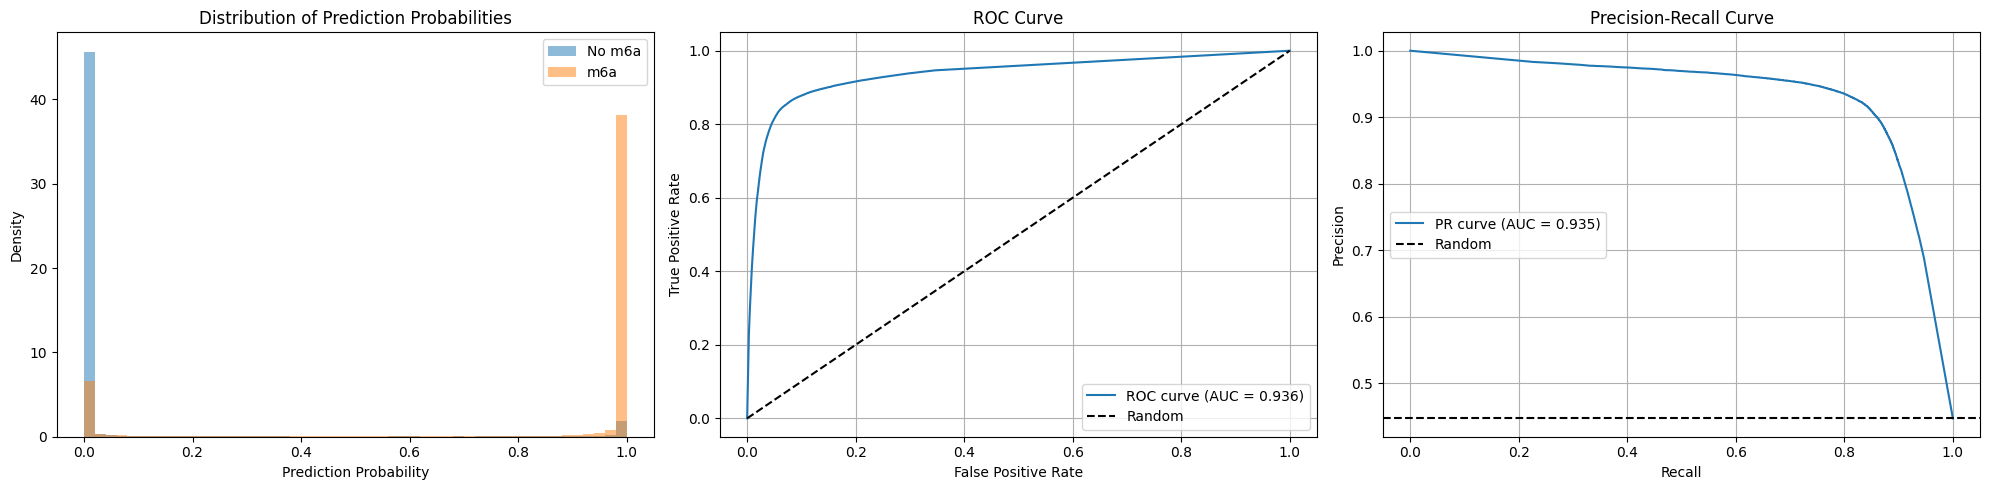


Detailed Prediction Analysis:
----------------------------------------
Confusion Matrix:
True Negatives: 109880
False Positives: 6483
False Negatives: 16059
True Positives: 78161
----------------------------------------
Performance Metrics:
Precision: 0.9234
Recall (Sensitivity): 0.8296
Specificity: 0.9443
F1 Score: 0.8740
----------------------------------------

Confidence Analysis:
High confidence predictions (>75%): 206269
High confidence errors: 20562
High confidence error rate: 0.0997


In [43]:
# Make predictions and analyze
predictions, true_labels, probabilities = predict_on_full_dataset(
    model=model,
    dataset=dataset,
    batch_size=32,
    device=device
)

# Analyze predictions in detail
analyze_predictions(predictions, true_labels, probabilities)

Predicting unlabelled datasets

In [44]:
def predict_on_new_dataset(model, dataset, batch_size=32, device='cuda'):
    """
    Make predictions on new dataset/dataset without labels
    
    Args:
        model: trained PyTorch model
        dataset: any unlabelled dataset
        batch_size: batch size for DataLoader
        device: device to run predictions on
    
    Returns:
        tuple: (predictions, probabilities)
    """
    # Create DataLoader for full dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Lists to store predictions
    all_predictions = []
    all_probs = []
    
    print("Making predictions on dataset...")
    
    with torch.no_grad():
        for data in dataloader:
            signal_features = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs).squeeze()
            
            # Store predictions and labels
            predictions = (site_level_probs > 0.5).float()
            
            all_predictions.append(predictions.cpu())
            all_probs.append(site_level_probs.cpu())
    
    # Concatenate all predictions and labels
    predictions = torch.cat(all_predictions)
    probabilities = torch.cat(all_probs)

    return predictions, probabilities


In [45]:
class NewRNANanoporeDataset(Dataset):
    """Dataset to predict new (non training) RNA Nanopore data"""

    def __init__(self, df, vectorizer, standardizer):
        """Initializes instance of class NewRNANanoporeDataset.

        Args:
            csv_file (str): Path to the csv file with the nanopore data
        """
        
        self.df = df
        X_df = process_new_data(df, vectorizer, standardizer) 

        # keep all trigram columns in input dataset
        self.X = X_df

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
    # Handle if idx is a tensor (converting to list if needed)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        signal_features = self.X.iloc[idx].values  

        # Convert to tensors
        signal_features = torch.tensor(signal_features, dtype=torch.float32)

        return signal_features
    
    def get_size(self):
        return len(self)


In [46]:
data_path = "../../dataset/d1_mean_final.csv"
v,s,a,b = pipeline_nn(pd.read_csv("../../dataset/mean_with_labels.csv")) # to get the vectorizer and standardizer based on training set of dataset0
#v = dataset.v #added vectorizer attribute to RNANanoporeDataset as a result of pipeline_nn which was based on dataset0
#s = dataset.s #added standardizer attribute to RNANanoporeDataset as a result of pipeline_nn which was based on dataset0
new_df = pd.read_csv(data_path)
new_dataset = NewRNANanoporeDataset(new_df, v, s)

# Make predictions
predictions, probabilities = predict_on_new_dataset(
    model=model,
    dataset=new_dataset,
    batch_size=32,
    device=device
)

FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/mean_with_labels.csv'

In [63]:
pred = pd.DataFrame(predictions.numpy().tolist(), columns=["class_prediction"])
print(pred.value_counts())

class_prediction
0.0                 78267
1.0                 12543
Name: count, dtype: int64


In [71]:
prob = pd.DataFrame(probabilities.numpy().tolist(), columns=["probability_modified"])
print(prob[prob["probability_modified"] > 0.5]) #rows where prob of modification > 0.5 which is current threshold for predicitng class 1 (modified)
cnt = prob[prob["probability_modified"] > 0.5].count()
print("number of rows with more than 0.5", cnt)

       probability_modified
33                 0.579720
58                 0.577213
80                 0.955249
119                0.990215
124                0.988291
...                     ...
90662              0.999852
90715              0.901850
90731              0.999802
90732              0.998697
90761              0.998995

[12543 rows x 1 columns]
number of rows with more than 0.5 probability_modified    12543
dtype: int64
